In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from clean import CleanData
import seaborn as sns
import json
from googletrans import Translator
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta

In [9]:
df = pd.read_csv("new_dfm.csv")
df["translated_lang"] = df["translated_lang"].astype(
    str)
df["translated_lang"] = df["translated_lang"].apply(
    lambda x: x.lower())
df["original_sound"] = df["translated_lang"].apply(lambda x: True if "original" in  x else False)
df["first_audio"] = df["musicMeta.musicOriginal"]

filter_df = df[["first_audio","original_sound",'shareRate','likeRate','commentRate']]
filter_df.loc[:,'first_audio'] = filter_df.loc[:,'first_audio'].replace(1,True).replace(0,False)

pivot_df = filter_df.groupby(['first_audio','original_sound'],as_index=False).size().rename(columns={"size": "videos_count"})
agg_df = filter_df.groupby(['first_audio','original_sound'],as_index=False).agg([np.mean])
pivot_df['avg_share_rate'] = agg_df.reset_index()['shareRate'][['mean']]
pivot_df['avg_like_rate'] = agg_df.reset_index()['likeRate'][['mean']]
pivot_df['avg_comment_rate'] = agg_df.reset_index()['commentRate'][['mean']]
pivot_df

C:\Users\Mattheus\anaconda3\envs\smm635\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,first_audio,original_sound,videos_count,avg_share_rate,avg_like_rate,avg_comment_rate
0,False,False,249,0.002022,0.087618,0.002088
1,False,True,5,0.000527,0.075364,0.001662
2,True,False,297,0.002086,0.106613,0.002209
3,True,True,449,0.002417,0.101524,0.002816


In [10]:
def get_music_data(pivot_df, rate_type, places=2):
    tt = round(float(pivot_df[(pivot_df['original_sound'] == True) & (pivot_df['first_audio'] == True)][rate_type]),places)
    tf = round(float(pivot_df[(pivot_df['original_sound'] == True) & (pivot_df['first_audio'] == False)][rate_type]),places)
    ft = round(float(pivot_df[(pivot_df['original_sound'] == False) & (pivot_df['first_audio'] == True)][rate_type]),places)
    ff = round(float(pivot_df[(pivot_df['original_sound'] == False) & (pivot_df['first_audio'] == False)][rate_type]),places)
    return [tt, tf, ft, ff]

In [11]:
def plot_lolipop(ax,rate_data,title,ylim,legend=False):
    tt = rate_data[0]
    tf = rate_data[1]
    ft = rate_data[2]
    ff = rate_data[3]
    
    ori_sound_color = 'navy'; music_color = 'firebrick'

    x = np.arange(11)
    y1 = [-5,-5]+[tt]+[-5,-5,-5]+[ft]+[-5,-5,-5,-5]
    y2 = [-5,-5,-5]+[tf]+[-5,-5,-5]+[ff]+[-5,-5,-5]
    height1 = [tt, ft]
    height2 = [tf, ff]    
    annotate = ['','',tt,tf,'','',ft,ff,'','','']

    # plot data
    ax.scatter(x, y1, marker='o', color=ori_sound_color,edgecolors='w')
    for i, txt in enumerate(annotate):
        ax.annotate(str(txt), (x[i], y1[i] + (y1[i]/25)), fontsize=10, horizontalalignment='right')
    ax.scatter(x, y2, marker='o', color=music_color,edgecolors='w')
    for i, txt in enumerate(annotate):
        ax.annotate(str(txt), (x[i], y2[i] + (y2[i]/25)), fontsize=10, horizontalalignment='left')

    ax.vlines(x=[2,6], ymin=0, ymax=height1, color=ori_sound_color,
            alpha=0.7, linewidth=1)
    ax.vlines(x=[3,7], ymin=0, ymax=height2, color=music_color,
            alpha=0.7, linewidth=1)

    # aesthetic changes
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_ylim(0,ylim)
    ax.axes.get_yaxis().set_visible(False)
    ax.tick_params(bottom=False, left=False)
    ax.set_xticks(np.arange(0, 10, 0.5))
    ax.set_xticklabels(['','','','','','Original Sound','','','','','','','','Music','','','','','',''])

    if legend == True:
        ax.legend(labels=['1st Upload','Not 1st Upload'],loc='upper right',fontsize=10)
    ax.set_title(title, y=-0.2)

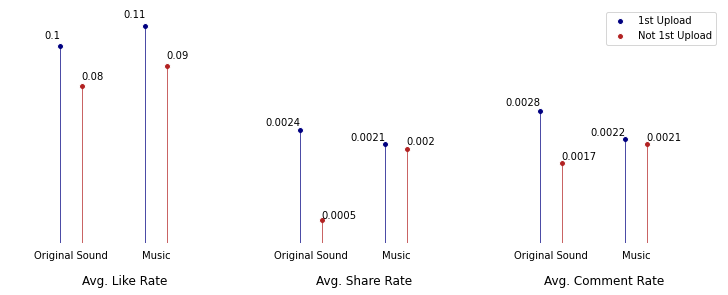

In [12]:
# figure
fig = plt.figure(figsize=(10, 4), constrained_layout=True)

# add plot
ax1 = fig.add_subplot(131)
plot_lolipop(ax1, get_music_data(pivot_df, 'avg_like_rate'),'Avg. Like Rate',0.12)

ax2 = fig.add_subplot(132)
plot_lolipop(ax2, get_music_data(pivot_df, 'avg_share_rate',4),'Avg. Share Rate',0.005)

ax3 = fig.add_subplot(133)
plot_lolipop(ax3, get_music_data(pivot_df, 'avg_comment_rate',4),'Avg. Comment Rate',0.005,legend=True)

fig.savefig('music_plot.jpg')
plt.show()

In [13]:
data = json.load(open('./data/trending.json', encoding="utf8"))
data = data['collector']
toParse = pd.json_normalize(data)
df = CleanData(toParse)
df.process_the_data()
df.summary_of_data()
df_clean = df.dfm

Missing Data:
None

Data Time Period:
Start Date: 2020-09-22 14:22:38
  End Date: 2020-12-21 03:18:36
 Timedelta: 89 days 12:55:58


In [14]:
df_clean['musicMeta.musicName'].unique()

array(['Element', 'Without Me', 'Pilfingerdansen - Remix',
       'Justin Timberlake - Mirrors', '原聲', 'Diamonds',
       'origineel geluid', 'original sound', 'Believer', 'Snort laugh',
       'WITHOUT YOU', 'Jailhouse Rock', 'Street Fashion Game',
       'som original', 'Originalton', 'original sound - 🌸Ri Za🌸',
       'ruin our friendship', 'Original Sound',
       'Blow Your Mind (Mwahchallenge)', 'EverybodyMakesMistakes',
       'hometown slowed down twenty one pilots', 'DUMB DUMB',
       'sonido original', 'Oh No',
       'Say So (Instrumental Version) [Originally Performed by Doja Cat]',
       'nhạc nền - ⚡Acacia⚡', 'Ishqa za tabah de krom',
       'reality can he whatever i want', 'COPYCAT x Bad Guy', 'Falling',
       'What You Know Bout Love', 'оригинальный звук', 'Palhação do Mal',
       'Photograph', 'Jingle Bell Rock',
       'verified ppl r using this im crying buh bye', 'KinjaBang',
       'Combination Taco Bell and Pizza Hut by Das Racist',
       'Sweet Dreams (A ca